## Imports

In [17]:
import torch
import torch.nn as nn
import torch.distributions as dist
from torch.func import jacfwd, hessian

import tqdm
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs

from tueplots.bundles import beamer_moml
import matplotlib.pyplot as plt
# Retina display
%config InlineBackend.figure_format = 'retina'

# Use render mode to run the notebook and save the plots in beamer format
# Use interactive mode to run the notebook and show the plots in notebook-friendly format
mode = "render"  # "interactive" or "render"

if mode == "render":
    width = 0.6
    plt.rcParams.update(beamer_moml(rel_width=width, rel_height=width * 0.8))
    # update marker size
    plt.rcParams.update({"lines.markersize": 4})
    plt.rcParams["figure.facecolor"] = "none"
else:
    plt.rcdefaults()

In [18]:
def plt_show(name=None):
    if mode == "interactive":
        plt.show()
    elif mode == "render":
        plt.savefig(f"../figures/bayesian-logistic-regression/{name}.pdf")
    else:
        raise ValueError(f"Unknown mode: {mode}")


## Data

In [19]:
X_np, y_np = make_blobs(
    n_samples=20, n_features=2, centers=2, random_state=11, cluster_std=1
)
df = pd.DataFrame(dict(x1=X_np[:, 0], x2=X_np[:, 1], y=y_np))

df.head(4)

,x1,x2,y
0,-5.973556,-10.676098,0
1,-0.439282,5.901450,1
2,-0.972880,3.266332,1
3,-5.298977,-9.920072,0


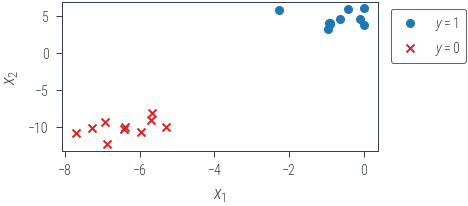

In [20]:
ones_df = df[df.y == 1]
zeros_df = df[df.y == 0]
plt.scatter(ones_df.x1, ones_df.x2, marker="o", label="$y=1$", c="tab:blue")
plt.scatter(zeros_df.x1, zeros_df.x2, marker="x", label="$y=0$", c="tab:red")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend(bbox_to_anchor=(1.3, 1))
plt_show("data")

In [21]:
if mode == "render":
    print(df.head(4).style.format("{:.2f}").to_latex())

\begin{tabular}{lrrr}
 & x1 & x2 & y \\
0 & -5.97 & -10.68 & 0.00 \\
1 & -0.44 & 5.90 & 1.00 \\
2 & -0.97 & 3.27 & 1.00 \\
3 & -5.30 & -9.92 & 0.00 \\
\end{tabular}



In [22]:
X, y = map(lambda x: torch.tensor(x, dtype=torch.float32), (X_np, y_np))
y = y.reshape(-1, 1)
X.shape, y.shape


(torch.Size([20, 2]), torch.Size([20, 1]))

## MLE

In [23]:
def negative_log_likelihood(theta, y):
    probs = torch.sigmoid(X @ theta)
    # print(probs.shape, y.shape)
    return -torch.sum(y * torch.log(probs) + (1 - y) * torch.log(1 - probs))


In [24]:
torch.manual_seed(42)
theta = torch.randn(2, 1, requires_grad=True)
epochs = 1000

optimizer = torch.optim.Adam([theta], lr=0.01)

losses = []
pbar = tqdm.trange(epochs)
for epoch in pbar:
    optimizer.zero_grad()
    loss = negative_log_likelihood(theta, y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    pbar.set_description(f"loss: {loss.item():.2f}")


loss: 0.02: 100%|██████████| 1000/1000 [00:01<00:00, 886.72it/s]


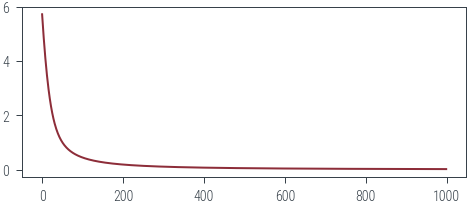

In [25]:
plt.plot(losses)


### Plot decision boundary

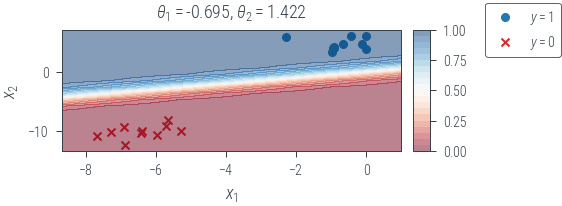

In [26]:
def plot_decision_boundary(name):
    x0_grid = torch.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 20).reshape(-1, 1)
    x1_grid = torch.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 20).reshape(-1, 1)
    X0, X1 = torch.meshgrid(x0_grid.ravel(), x1_grid.ravel())

    f = lambda x1, x2: torch.sigmoid(theta[0] * x1 + theta[1] * x2).squeeze()
    f = torch.vmap(torch.vmap(f))

    with torch.no_grad():
        probs = f(X0, X1)

    fig, ax = plt.subplots(1, 2, gridspec_kw=dict(width_ratios=[1, 0.05]))
    ax[0].scatter(ones_df.x1, ones_df.x2, marker="o", label="$y=1$", c="tab:blue")
    ax[0].scatter(zeros_df.x1, zeros_df.x2, marker="x", label="$y=0$", c="tab:red")
    mappable = ax[0].contourf(
        X0, X1, probs, levels=20, alpha=0.5, cmap="RdBu", vmin=0, vmax=1
    )
    ax[0].set_xlabel("$x_1$")
    ax[0].set_ylabel("$x_2$")
    sigma_term = "$\sigma^2$" + f" = {variance:.3f}, " if name.startswith("map") else ""
    ax[0].set_title(
        sigma_term
        + "$\\theta_1 = $"
        + f"{theta[0].item():.3f}, $\\theta_2 = $"
        + f"{theta[1].item():.3f}"
    )
    cbar = fig.colorbar(mappable, ticks=np.linspace(0, 1, 5), cax=ax[1])
    fig.legend(bbox_to_anchor=(1.2, 1))
    plt_show(name)


plot_decision_boundary("mle")


## MAP

In [27]:
def neg_log_prior(theta, variance):
    return -dist.Normal(0, variance**0.5).log_prob(theta).sum()


def negative_log_joint(theta, variance):
    return (
        negative_log_likelihood(theta, y).sum() + neg_log_prior(theta, variance)
    ).squeeze()


In [28]:
torch.manual_seed(42)
variance = 0.01
theta = torch.randn(2, 1, requires_grad=True)
epochs = 500

optimizer = torch.optim.Adam([theta], lr=0.01)

losses = []
pbar = tqdm.trange(epochs)
for epoch in pbar:
    optimizer.zero_grad()
    loss = negative_log_joint(theta, variance).mean()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    pbar.set_description(f"loss: {loss.item():.2f}")


loss: 3.78: 100%|██████████| 500/500 [00:00<00:00, 658.82it/s]


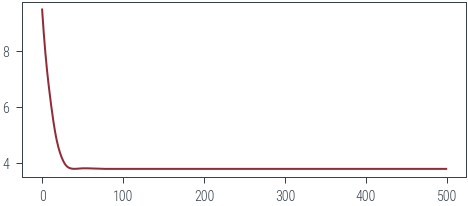

In [29]:
plt.plot(losses)

### Plot decision boundary

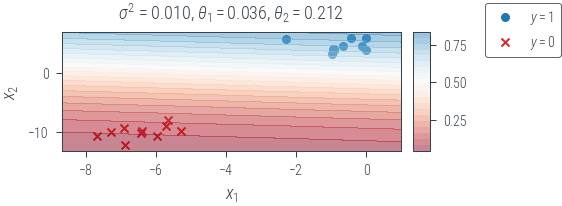

In [30]:
plot_decision_boundary(f"map_{variance}")


## Laplace approximation

In [31]:
with torch.no_grad():
    probs = torch.sigmoid(X @ theta)
hess = hessian(negative_log_joint)(theta.ravel(), torch.tensor(variance))

cov = torch.inverse(hess)
print(cov)
posterior = dist.MultivariateNormal(theta.ravel(), cov)

tensor([[ 0.0020, -0.0007],
        [-0.0007,  0.0006]], grad_fn=<LinalgInvExBackward0>)


torch.Size([1000, 20, 20])


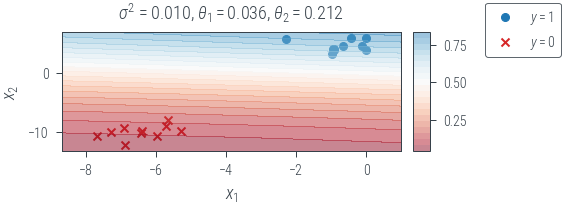

In [32]:
name = f"map_laplace-{variance}"
x0_grid = torch.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 20).reshape(-1, 1)
x1_grid = torch.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 20).reshape(-1, 1)
X0, X1 = torch.meshgrid(x0_grid.ravel(), x1_grid.ravel())


def get_probs(theta):
    f = lambda x1, x2: torch.sigmoid(theta[0] * x1 + theta[1] * x2).squeeze()
    f = torch.vmap(torch.vmap(f))

    with torch.no_grad():
        probs = f(X0, X1)
    return probs


theta_samples = posterior.sample((1000,))
probs = torch.stack([get_probs(theta) for theta in theta_samples])
print(probs.shape)
probs = probs.mean(0)

fig, ax = plt.subplots(1, 2, gridspec_kw=dict(width_ratios=[1, 0.05]))
ax[0].scatter(ones_df.x1, ones_df.x2, marker="o", label="$y=1$", c="tab:blue")
ax[0].scatter(zeros_df.x1, zeros_df.x2, marker="x", label="$y=0$", c="tab:red")
mappable = ax[0].contourf(
    X0, X1, probs, levels=20, alpha=0.5, cmap="RdBu", vmin=0, vmax=1
)
ax[0].set_xlabel("$x_1$")
ax[0].set_ylabel("$x_2$")
sigma_term = "$\sigma^2$" + f" = {variance:.3f}, " if name.startswith("map") else ""
ax[0].set_title(
    sigma_term
    + "$\\theta_1 = $"
    + f"{theta[0].item():.3f}, $\\theta_2 = $"
    + f"{theta[1].item():.3f}"
)
cbar = fig.colorbar(mappable, ticks=np.linspace(0, 1, 5), cax=ax[1])
fig.legend(bbox_to_anchor=(1.2, 1))
plt_show(name)


## Appendix

Can we find closed form MLE solution for Bayesian Logistic Regression? It seems, yes. Stay tuned!